In [ ]:
#!pip install torch

In [ ]:
#!pip install torchvision

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("Student.csv")
df.head()

,Maths,Physics,Chemistry,Result
0,17,27,22,0
1,72,82,77,1
2,97,18,13,0
3,8,42,37,0
4,32,25,20,0


<AxesSubplot:xlabel='Result', ylabel='count'>

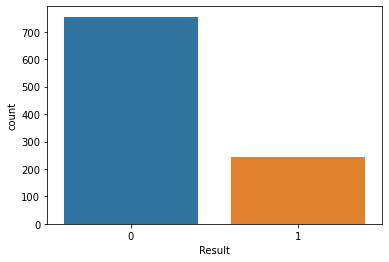

In [3]:
sns.countplot(x = 'Result', data=df)

The last column is our output. The input is all the columns but the last one.

In [4]:
#convert imput to numpy arrays
X = df.drop(columns=['Result'])

In [5]:
y= df['Result']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [7]:
print(f"Shape of train set is {X_train.shape}")
print(f"Shape of test set is {X_test.shape}")
print(f"Shape of train label is {y_train.shape}")
print(f"Shape of test labels is {y_test.shape}")

Shape of train set is (800, 3)
Shape of test set is (200, 3)
Shape of train label is (800,)
Shape of test labels is (200,)


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
EPOCHS = 50
BATCH_SIZE = 100
LEARNING_RATE = 0.001

In [10]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [11]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [12]:
#2 layer Feed-Forward network with BatchNorm and Dropout


#Note: I did not use the Sigmoid activation in our final layer during training. That’s because, we use the nn.BCEWithLogitsLoss() loss function which automatically applies the the Sigmoid activation.

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 3.
        self.layer_1 = nn.Linear(3, 100) 
        self.layer_2 = nn.Linear(100, 100)
        self.layer_out = nn.Linear(100, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(100)
        self.batchnorm2 = nn.BatchNorm1d(100)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


After this, we initialize our optimizer and decide on which loss function to use.

In [14]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=3, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=100, bias=True)
  (layer_out): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


**Train the model**

In [15]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
#We do optimizer.zero_grad() before we make any predictions. Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.

model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.54822 | Acc: 70.000
Epoch 002: | Loss: 0.36409 | Acc: 85.250
Epoch 003: | Loss: 0.29482 | Acc: 90.500
Epoch 004: | Loss: 0.25093 | Acc: 92.625
Epoch 005: | Loss: 0.21661 | Acc: 93.750
Epoch 006: | Loss: 0.18262 | Acc: 93.875
Epoch 007: | Loss: 0.15883 | Acc: 95.875
Epoch 008: | Loss: 0.14057 | Acc: 96.750
Epoch 009: | Loss: 0.12936 | Acc: 96.000
Epoch 010: | Loss: 0.11426 | Acc: 96.625
Epoch 011: | Loss: 0.11509 | Acc: 96.375
Epoch 012: | Loss: 0.10570 | Acc: 96.375
Epoch 013: | Loss: 0.08771 | Acc: 97.500
Epoch 014: | Loss: 0.08787 | Acc: 97.000
Epoch 015: | Loss: 0.08912 | Acc: 97.250
Epoch 016: | Loss: 0.09238 | Acc: 96.750
Epoch 017: | Loss: 0.08116 | Acc: 96.875
Epoch 018: | Loss: 0.06558 | Acc: 97.750
Epoch 019: | Loss: 0.07750 | Acc: 97.500
Epoch 020: | Loss: 0.06834 | Acc: 98.000
Epoch 021: | Loss: 0.08219 | Acc: 96.750
Epoch 022: | Loss: 0.06997 | Acc: 97.125
Epoch 023: | Loss: 0.05944 | Acc: 98.125
Epoch 024: | Loss: 0.05918 | Acc: 97.500
Epoch 025: | Los

In [17]:
#To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad() which reduces memory usage and speeds up computation.

y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
confusion_matrix(y_test, y_pred_list)


array([[156,   1],
       [  2,  41]], dtype=int64)

In [19]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       157
           1       0.98      0.95      0.96        43

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.98      0.98       200

